# Project 3

Required libraries imported below

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

Data Generation

In [2]:
def is_dangerous(color_choices):
    if 3 in color_choices and 1 not in color_choices:
        return True
    return False

def one_hot_encode(color):
    arr = np.zeros(4)    
    arr[color-1] = 1
    return arr
    
def generate_wiring_diagram(part): #part signfies the part of the project the data is being generated for (1 or 2)
    if part != 1 and part != 2:
        print("invalid parameter values entered while calling generate_wiring_diagram(part) function, part can either be 1 or 2")
        return
    
    diagram = np.zeros((20,20,4), dtype=int) # Initializing a 20x20 blank diagram
    color_choices = [1, 2, 3, 4] # 1: Red, 2: Blue, 3: Yellow, 4: Green
    row_choices = list(range(0,20))
    col_choices= list(range(0,20))
    dangerous = False
    wire_to_cut = 0 # 0: No wire to cut, 1: Red, 2: Blue, 3: Yellow, 4: Green

    start_with_row = random.choice([True, False])
    
    if start_with_row: # True: Start with row, False: Start with column
        for i in range(4):
            if i%2 == 0:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[row, :] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, col] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==3: # If the diagram is dangerous, the third wire placed is the one to cut
                wire_to_cut = color
                
    else:
        for i in range(4):
            if i%2 == 0:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[col, :] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, row] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==3:
                wire_to_cut = color # If the diagram is dangerous, the third wire placed is the one to cut

    if part == 1: 
        return diagram, dangerous # If part is 1, return the diagram and whether it is dangerous or not
    elif part == 2:
        return diagram, wire_to_cut # If part is 2, return the diagram and the wire to cut
        


Memory Class to store dataset

In [3]:
# Creating a class to create our "dataset" for model training
class Memory:
    # Constructor
    def __init__(self, max_memory):
        self.max_memory = max_memory # maximum amount of samples to remember
        self.samples = [] # the samples

    # Adding a sample to memory
    def add_sample(self, diagram_vector, y):
        if [diagram_vector, y] not in self.samples: # Checking if the sample is already in memory
            self.samples.append((diagram_vector, y))
        if len(self.samples) > self.max_memory: # Removing the earliest sample if we reach maximum memory
            self.samples.pop(0)
        return len(self.samples)
    

    # Sampling the samples we have in memory
    def sample(self, no_samples): #no_samples is the number of samples you need
        if no_samples > len(self.samples):
            return random.sample(self.samples, len(self.samples))
        else:
            return random.sample(self.samples, no_samples)

Data generation for part 1

In [4]:
diagrams = 5000 #number of max diagrams to be stored in Memory class
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed
diagram_arr = []
training_size = 100
testing_size = 100
for i in range(diagrams):
    diagram, y = generate_wiring_diagram(1) #type:ignore
    memory.add_sample(diagram, int(y == True))
samples = memory.sample(training_size+testing_size)
training_data = samples[:training_size]
testing_data = samples[training_size:]
x_train = []
y_train = []
x_test = []
y_test = []
for diagram in training_data:
    x_train.append(np.concatenate(([1], diagram[0].flatten()))) #A vector with each component being a vector of the each sample diagram's features
    y_train.append(diagram[1])
for diagram in testing_data:
    x_test.append(np.concatenate(([1], diagram[0].flatten()))) #A vector with each component being a vector of the each sample diagram's features
    y_test.append(diagram[1])

Model for Part 1

In [52]:
class LogisticRegressionModel():
    def __init__(self, weights, alpha, epochs):
        self.weights = weights
        self.alpha = alpha
        self.epochs = epochs
        self.train_loss_history = []
        self.test_loss_history = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log(self, x):
        return np.log10(x)

    def costFunction (self, features, weights, y): #Loss Function
        loss = 0
        for i in range(len(weights)):
            loss += -1 * self.y[i] * self.log(self.sigmoid(np.dot(weights[i], features[i])) - (1-y[i]) * self.log(self.sigmoid(1-np.dot(weights[i], features[i]))))
        loss /= 1/len(weights-1)
        return loss

    def gradientDescent(self, features, weights, alpha, y):
        gradient = np.zeros(len(weights))
        for j in range(len(weights)): #Loop through each through weights to update them
            for i in range(len(features)): #Loop through each index for each pixel in the the diagram
                func = self.sigmoid(np.dot(features, weights))
                gradient[j] += (func-y) * features[i]
        weights = weights - alpha * gradient

    def fit(self, weights, alpha, x_train, y_train, x_test, y_test, epochs):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        for i in range(epochs):
            for j in range(len(x_train)): #Loop through each sample in the dataset
                self.gradientDescent(x_train[j], weights, alpha, y_train[j])           

weights = np.random.randn(len(x_train[0]))    
alpha = 0.05 # Left at 0.05 for now
epochs = 5
model = LogisticRegressionModel(weights, alpha, epochs)
model.fit(weights, alpha, x_train, y_train, x_test, y_test, epochs)

Data generation for part 2

In [111]:
diagrams = 6000 #number of max diagrams to be stored in Memory class
train_size = 500 #number of samples to be generated
test_size = 1000 #number of samples to be used for testing
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed

#generating 5000 diagrams and storing them in memory
len_samples = 0
while len_samples!=diagrams:
    diagram, y = generate_wiring_diagram(2) #type:ignore
    if y != 0:
        len_samples = memory.add_sample(diagram, y)
samples = memory.sample(train_size+test_size)

train_samples = samples[:train_size]
test_samples = samples[train_size:]

diagram_arr = []
y_arr = []
for diagrams, y in train_samples:
    diagram_arr.append(diagrams)
    y_arr.append(y)
    
test_diagram_arr = []
test_y_arr = []    
for test_diagrams, test_y in test_samples:
    test_diagram_arr.append(test_diagrams)
    test_y_arr.append(test_y)

y_arr = np.array(y_arr) #converting the y_arr to a numpy array for easier computation
test_y_arr = np.array(test_y_arr) #converting the test_y_arr to a numpy array for easier computation

Data Processing

In [112]:
def process_data(diagram_arr, y_arr):
    flattened_diagrams = np.array([diagram.flatten() for diagram in diagram_arr])
    additional_features = np.array([diagram.sum(axis=(0, 1)) for diagram in diagram_arr])
    additional_features = (np.exp(np.subtract(additional_features, 18)))
    X_combined = np.concatenate((flattened_diagrams, additional_features), axis=1)
    X = np.c_[X_combined, np.ones(X_combined.shape[0])]
    Y = np.eye(4)[np.subtract(y_arr,1)]
    
    return X, Y

In [113]:
X_train, Y_train = process_data(diagram_arr, y_arr)
X_test, Y_test = process_data(test_diagram_arr, test_y_arr)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"First element of X_train: {X_train[0]}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"First element of X_test: {X_test[0]}")

X_train shape: (500, 1605)
Y_train shape: (500, 4)
First element of X_train: [0.         0.         0.         ... 2.71828183 2.71828183 1.        ]
X_test shape: (1000, 1605)
Y_test shape: (1000, 4)
First element of X_test: [0.         0.         0.         ... 7.3890561  2.71828183 1.        ]


Part 2 implementation

In [13]:
#defining the softmax function
def softmax(x): 
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [84]:
class Model():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.epsilon = 1e-10
        self.regularization = 0.01
        self.train_loss_history = []
        self.test_loss_history = []
        
    def fit(self, X_train, Y_train, X_test, Y_test, learning_rate = 0.001, epochs = 10):
        m = X_train.shape[0]
        for epoch in range(epochs):
            
            #forward propagation for training
            Z_train = np.dot(X_train, self.W) + self.b
            A_train = softmax(Z_train)
            
            loss_train = -np.mean(np.sum(Y_train * np.log(A_train + self.epsilon), axis=1)) #calculating the loss
            loss_train += 0.5 * self.regularization * np.sum(self.W ** 2) #calculating the regularization loss
            
            self.train_loss_history.append(loss_train)
            
            # Forward pass for test data
            Z_test = np.dot(X_test, self.W) + self.b
            A_test = softmax(Z_test)
            
            loss_test = -np.mean(np.sum(Y_test * np.log(A_test + self.epsilon), axis=1))
            loss_test += 0.5 * self.regularization * np.sum(self.W ** 2)
            self.test_loss_history.append(loss_test)
            
            #calculating the gradients
            dW = (1/m) * np.dot(X_train.T, (A_train-Y_train)) + (self.regularization * self.W)
            db = (1/m) * np.sum(A_train-Y_train, axis=0) + (self.regularization * self.b)
            
            #updating the weights and biases
            self.W -= learning_rate * dW 
            self.b -= learning_rate * db
            
            print("Epoch: ", epoch, "Loss: ", loss_train)
        
        self.plot_loss(self.train_loss_history, self.test_loss_history)
                
    def predict(self, X): #prediction function
        Z = np.dot(X, self.W) + self.b
        probs = softmax(Z)
        return np.argmax(probs, axis=1) + 1
    
    #plotting the loss
    def plot_loss(self, train_loss_history, test_loss_history):
        plt.plot(train_loss_history, label = "train loss")
        plt.plot(test_loss_history, label = "test loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.show()
    
    #saving and loading the model
    def save_model(self, name):
        np.savez(name, W=self.W, b=self.b)
        
    def load_model(self, name):
        loaded_data = np.load(name)
        self.W = loaded_data['W']
        self.b = loaded_data['b']

In [119]:
num_classes = 4
num_features = X_train.shape[1]
W = np.random.rand(num_features, num_classes)
b = np.zeros(num_classes)
model = Model(W, b)

(1605, 4)


In [93]:
model.load_model('model_non_linear.npz')  # Load weights from a saved file

Epoch:  0 Loss:  14.009130667809378
Epoch:  1 Loss:  12.527897147461895
Epoch:  2 Loss:  11.971611775539856
Epoch:  3 Loss:  11.607801968186234
Epoch:  4 Loss:  11.352055775190552
Epoch:  5 Loss:  11.165659395838789
Epoch:  6 Loss:  11.025381051802084
Epoch:  7 Loss:  10.916411257969514
Epoch:  8 Loss:  10.829110810966203
Epoch:  9 Loss:  10.757109306592167
Epoch:  10 Loss:  10.696129111887139
Epoch:  11 Loss:  10.643248791788482
Epoch:  12 Loss:  10.596437838284029
Epoch:  13 Loss:  10.554259262394796
Epoch:  14 Loss:  10.515677432578784
Epoch:  15 Loss:  10.47993263746716
Epoch:  16 Loss:  10.446458186828847
Epoch:  17 Loss:  10.414824787913807
Epoch:  18 Loss:  10.384702584089865
Epoch:  19 Loss:  10.355834794318953
Epoch:  20 Loss:  10.328019101760768
Epoch:  21 Loss:  10.30109431058796
Epoch:  22 Loss:  10.274930645661474
Epoch:  23 Loss:  10.249422610754928
Epoch:  24 Loss:  10.224483669101547
Epoch:  25 Loss:  10.200042238219641
Epoch:  26 Loss:  10.176038643338897
Epoch:  27 Lo

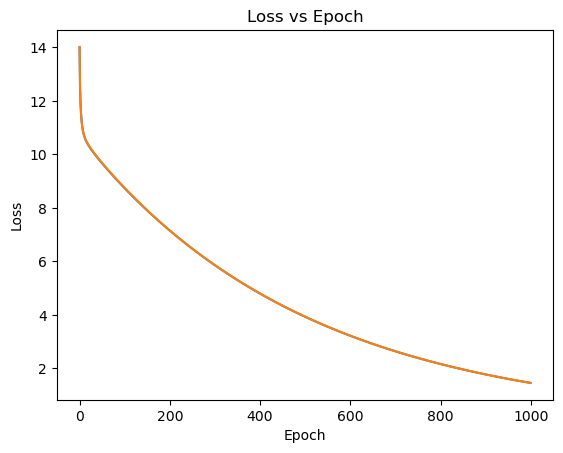

In [120]:
#training the model
model.fit(X_train, Y_train, X_test, Y_test, learning_rate=0.1, epochs = 1000)

In [121]:
predictions = model.predict(X_test)

correct_predictions = np.sum(predictions == test_y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_test.shape[0])*100
print(f"Accuracy on test set: {accuracy}")


1000
Accuracy on test set: 100.0


In [117]:
predictions = model.predict(X_train)

correct_predictions = np.sum(predictions == y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_train.shape[0])*100
print(f"Accuracy on training set: {accuracy}")


500
Accuracy on training set: 100.0


In [104]:
model.save_model("model_non_linear.npz")